# Smoothing particles

In [1]:
# Libraries ----
import sys  # type: ignore
import warnings

import imageio  # type: ignore
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

sys.path.append("../modules")
import plot_clustering as plt_cp  # type: ignore
import plot_smoothing as plt_sp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import smoothing_particles as sp  # type: ignore
import track_particles as tp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

ordering = True
video_name = "3n_3m_0f_240214_3"
n_particles = int(video_name[0])
save_figures = True
x_bounds = [0, 1080]
y_bounds = [70, 1840]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Load tracked data

In [3]:
df_tracked = pd.read_csv(
    "{}/clustered_{}.csv".format(output_path, video_name), low_memory=False
)
df_tracked.head(n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,1708.229911,117.338472,1707.978477,117.708541,0.0,1702.0,56.0,0.168627,1680.0,88.0,0.157562,6098.0,120.433016,78.042325,0.761628,3,NaN,NaN,NaN,NaN,False,False,False
1,1,0,1101.301167,1009.758075,1098.503485,1007.652490,0.0,1020.0,962.0,0.741176,1069.0,1043.0,-1.393966,12508.0,246.097324,87.498857,0.934659,3,NaN,NaN,NaN,NaN,False,False,False
2,2,0,722.803217,1014.625220,727.750925,1012.168692,0.0,894.0,963.0,0.956863,686.0,984.0,1.451087,7399.0,167.167828,79.452743,0.879831,3,NaN,NaN,NaN,NaN,False,False,False


In [4]:
df_tracked.tail(n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
35997,0,35997,1705.604301,126.577063,1704.117776,124.255335,0.0,1691.937500,49.000000,0.411765,1720.474023,99.100003,0.302749,6744.0,130.764317,71.394739,0.837798,3,3.0,-0.005192,-0.010877,0.0,False,False,False
35998,1,35997,1746.845388,204.903471,1746.246993,203.948675,NaN,1691.000000,49.000000,NaN,1696.546337,60.776446,-0.173216,291.0,224.748196,72.206169,0.946986,3,3.0,0.000000,0.000000,0.0,False,False,False
35999,2,35997,1745.342215,245.499469,1745.167493,249.324684,NaN,1745.342215,245.499469,NaN,1745.342215,245.499469,-0.318311,243.0,166.580095,73.480340,0.897452,3,3.0,0.000000,0.000000,0.0,False,False,False


## Swapping mixed IDs

In [5]:
omega_threshold = 20 * np.pi / 180  # Angular velocity per frame (in degrees)
velocity_threshold = 83  # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
delta = 400

from importlib import reload
reload(sp)

arg_list = [
    # VIDEO 1
    [0    , 10000, velocity_threshold, omega_threshold, True],
    [10000, 20000, velocity_threshold, omega_threshold, True],
    [20000, 30000, velocity_threshold, omega_threshold, True],
    [30000, 36000, velocity_threshold, omega_threshold, True]#,
    # [40000, 50000, velocity_threshold, omega_threshold, True],
    # [50000, 60000, velocity_threshold, omega_threshold, True],
    # [60000, 70000, velocity_threshold, omega_threshold, True],
    # [70000, 80000, velocity_threshold, omega_threshold, True],
    # [80000, 90000, velocity_threshold, omega_threshold, True],
    # [90000, 100000, velocity_threshold, omega_threshold, True],
    # [100000, 108311, velocity_threshold, omega_threshold, True]
]

df_final = sp.smooth_frames(
    df_tracked=df_tracked,
    arg_list=arg_list,
    order=False,
    log_path=log_path,
    log_filename="log_{}".format(video_name),
    verbose=1,
    tqdm_bar=True
)

df_final.head(8)

Thresholds:
	- Velocity: 83 
	- Angle: 20.0 



100%|█████████████████████████| 4/4 [00:30<00:00,  7.63s/it]


Time: 30000 Chunks 2 Allowed time 30000 Permutation [0 1 2]


,allowed_frame,time,smooth_chunk,id,permuted_id,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,corrected_orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,True,0,chunk_00000_10000,0,0,1708.229911,117.338472,1707.978477,117.708541,0.0,1702.0,56.0,0.168627,1680.0,88.0,0.157562,0.157562,6098.0,120.433016,78.042325,0.761628,3,NaN,NaN,NaN,NaN,False,False,False
1,True,0,chunk_00000_10000,1,1,1101.301167,1009.758075,1098.503485,1007.652490,0.0,1020.0,962.0,0.741176,1069.0,1043.0,-1.393966,-1.393966,12508.0,246.097324,87.498857,0.934659,3,NaN,NaN,NaN,NaN,False,False,False
2,True,0,chunk_00000_10000,2,2,722.803217,1014.625220,727.750925,1012.168692,0.0,894.0,963.0,0.956863,686.0,984.0,1.451087,1.451087,7399.0,167.167828,79.452743,0.879831,3,NaN,NaN,NaN,NaN,False,False,False
3,False,3,chunk_00000_10000,0,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.168627,NaN,NaN,NaN,NaN,6041.0,119.823306,78.032631,0.758880,3,3.0,NaN,NaN,NaN,False,False,False
4,False,3,chunk_00000_10000,1,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.741176,NaN,NaN,NaN,NaN,12432.0,243.918959,87.489889,0.933459,3,3.0,NaN,NaN,NaN,False,False,False
5,False,3,chunk_00000_10000,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,325.0,299.298880,61.592962,0.978596,3,3.0,NaN,NaN,NaN,True,False,False
6,False,6,chunk_00000_10000,0,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.168627,NaN,NaN,NaN,NaN,6041.0,119.823306,78.032631,0.758880,3,3.0,NaN,NaN,NaN,False,False,False
7,False,6,chunk_00000_10000,1,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.741176,NaN,NaN,NaN,NaN,12432.0,243.918959,87.489889,0.933459,3,3.0,NaN,NaN,NaN,False,False,False


In [6]:
df_final.tail(5)

,allowed_frame,time,smooth_chunk,id,permuted_id,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,corrected_orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
35995,True,35994,chunk_30000_36000,1,1,1746.845388,204.903471,1746.246993,203.948675,NaN,1691.000000,49.000000,NaN,1696.546337,60.776446,-0.173216,-0.173216,291.0,224.748196,72.206169,0.946986,3,3.0,0.000000,0.000000,0.0,False,False,False
35994,True,35994,chunk_30000_36000,0,2,1705.619878,126.609694,1704.130211,124.287113,0.0,1691.875000,49.000000,0.411765,1714.948045,99.200005,0.302749,0.302749,6744.0,130.764317,71.394739,0.837798,3,3.0,-0.005933,0.002937,0.0,False,False,False
35999,True,35997,chunk_30000_36000,2,0,1745.342215,245.499469,1745.167493,249.324684,NaN,1745.342215,245.499469,NaN,1745.342215,245.499469,-0.318311,-0.318311,243.0,166.580095,73.480340,0.897452,3,3.0,0.000000,0.000000,0.0,False,False,False
35998,True,35997,chunk_30000_36000,1,1,1746.845388,204.903471,1746.246993,203.948675,NaN,1691.000000,49.000000,NaN,1696.546337,60.776446,-0.173216,-0.173216,291.0,224.748196,72.206169,0.946986,3,3.0,0.000000,0.000000,0.0,False,False,False
35997,True,35997,chunk_30000_36000,0,2,1705.604301,126.577063,1704.117776,124.255335,0.0,1691.937500,49.000000,0.411765,1720.474023,99.100003,0.302749,0.302749,6744.0,130.764317,71.394739,0.837798,3,3.0,-0.005192,-0.010877,0.0,False,False,False


## Interpolation over not allowed frames

In [7]:
if ordering:
    df_full = df_final.copy().sort_values(["time", "permuted_id"])
    for id_ in range(len(df_full["permuted_id"].unique())):
        mask = df_full.loc[:, "permuted_id"] == df_full["permuted_id"].unique()[id_]
        df_full[mask] = df_full[mask].interpolate(method="linear")

In [8]:
if ordering:
    cols = [
        "id",
        "permuted_id",
        "time",
        "position_x",
        "position_y",
        "weighted_x",
        "weighted_y",
        "darkest_v",
        "darkest_x",
        "darkest_y",
        "lightest_v",
        "lightest_x",
        "lightest_y",
        "orientation",
        "corrected_orientation",
        "area",
        "axis_major",
        "axis_minor",
        "eccentricity",
    ]
    df_temp = df_full[cols]
    df_temp.to_csv(
        "{}/interpolated_{}.csv".format(output_path, video_name), index=False
    )
    df_temp

Thresholds:
	- Velocity: 2.2579384890249905 
	- Angle: 0.427531291215712 



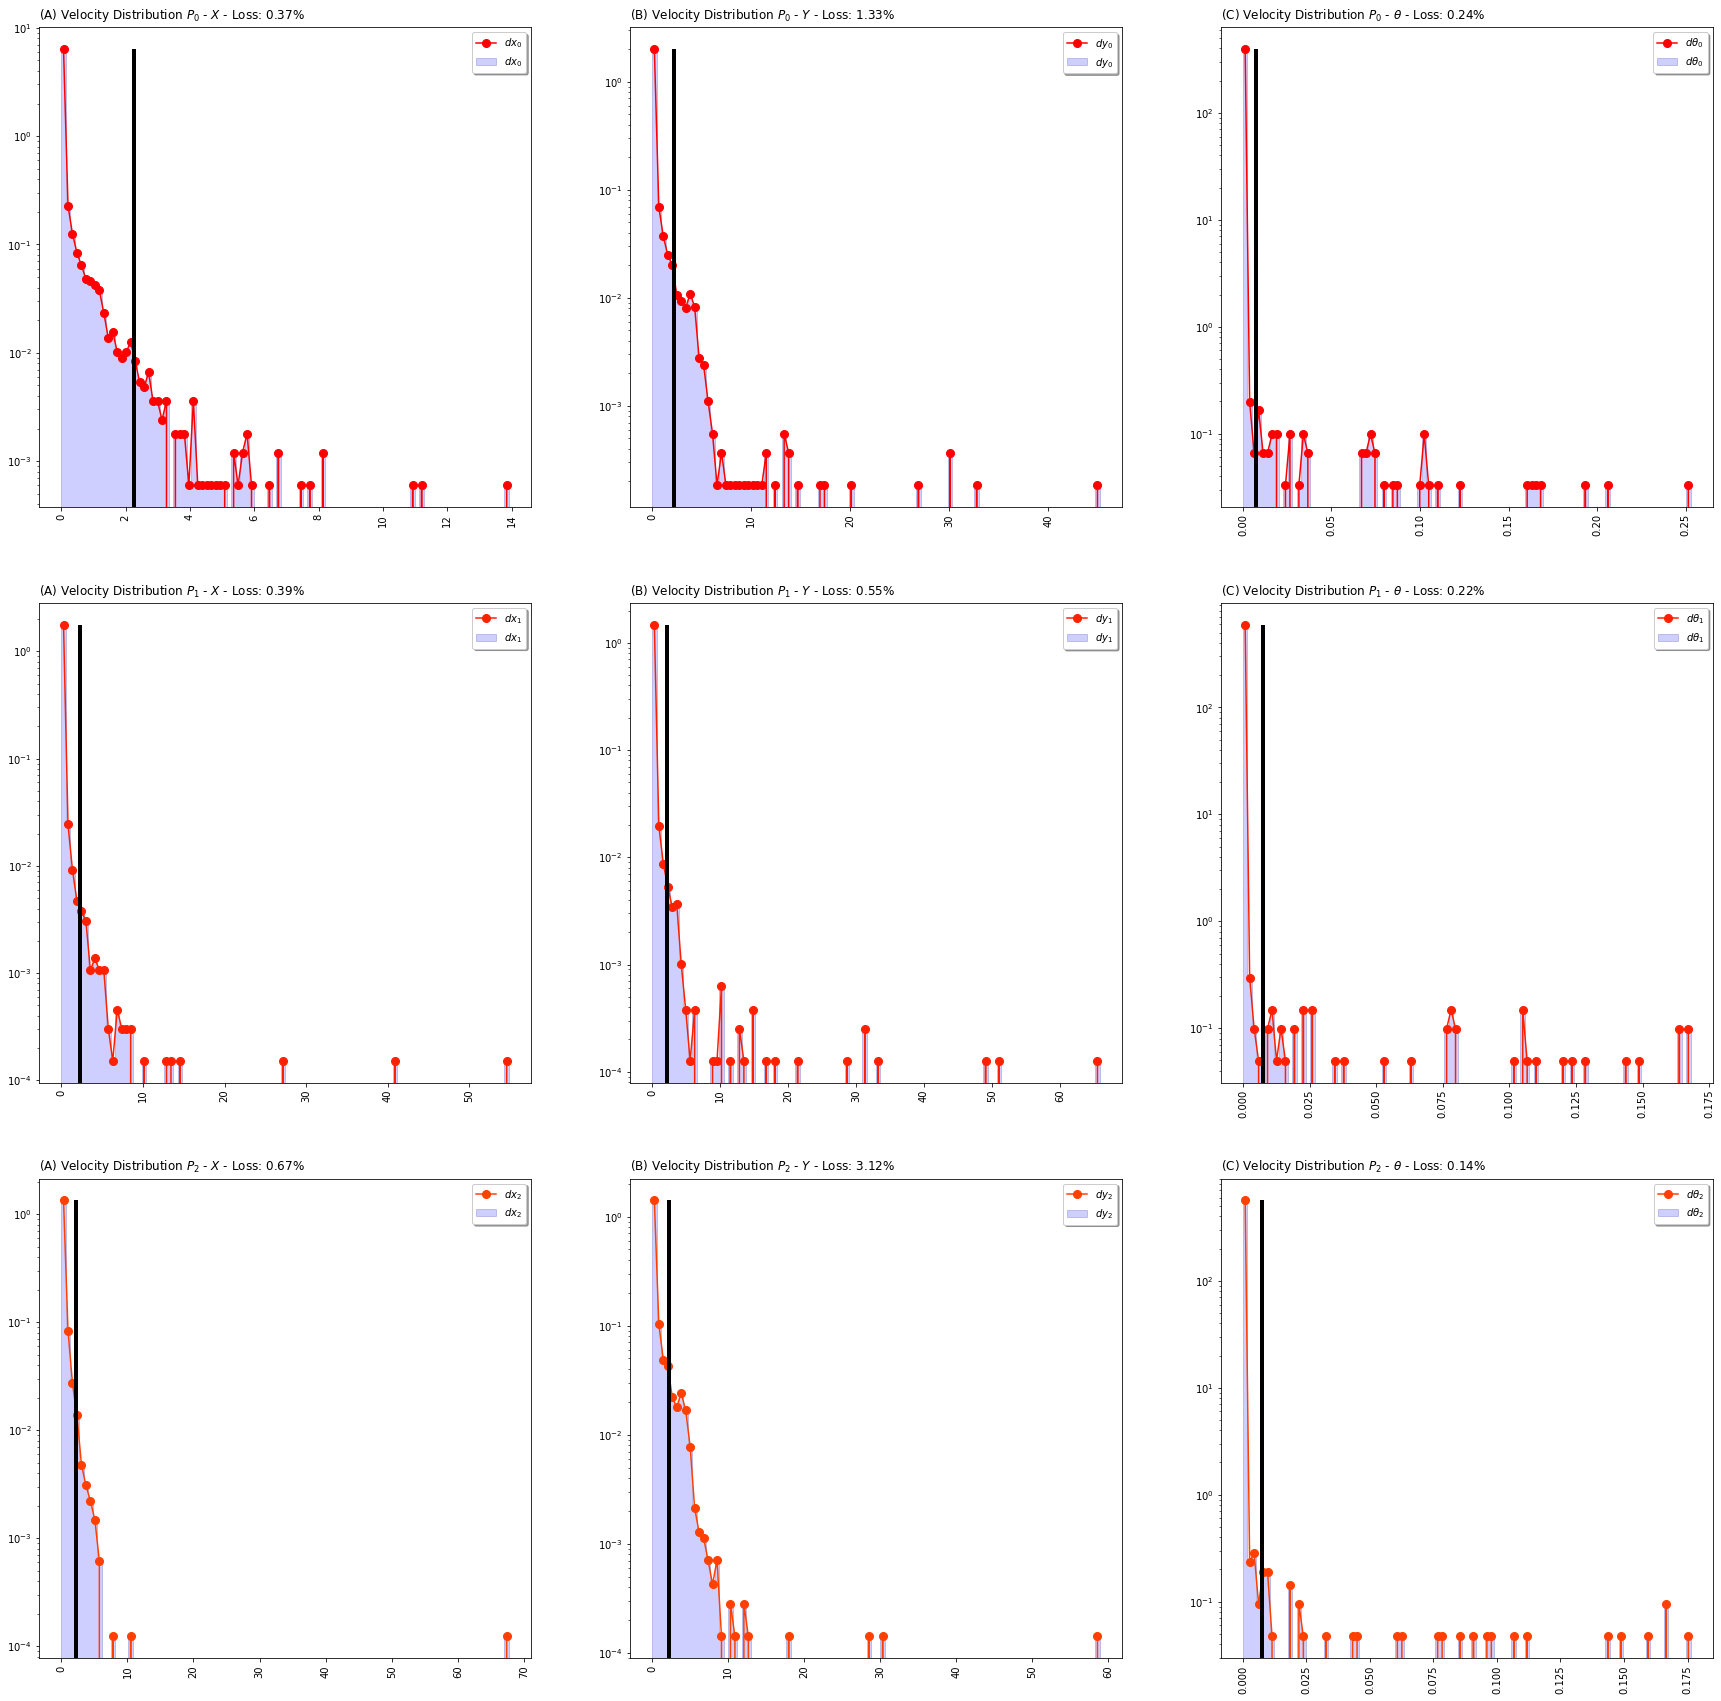

In [9]:
if ordering:
    bins = 100
    width = 10
    fancy_legend = True
    omega_threshold = (
        df_full["velocity_orientation"].abs().quantile(0.9965)
    )  # Angular velocity per frame
    velocity_threshold = (
        df_full["velocity_x"].abs().quantile(0.9901)
    )  # Velocity per frame limited with half average size of particle
    print(
        "Thresholds:\n\t- Velocity:",
        velocity_threshold,
        "\n\t- Angle:",
        omega_threshold * 180 / np.pi,
        "\n",
    )

    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    df_smooth["orientation"] = df_smooth["corrected_orientation"]
    plt_cp.plot_velocities_distribution(
        df_tracked=df_smooth,
        bins=bins,
        velocity_threshold=velocity_threshold,
        omega_threshold=omega_threshold,
        width=width,
        fancy_legend=fancy_legend,
    )

Original


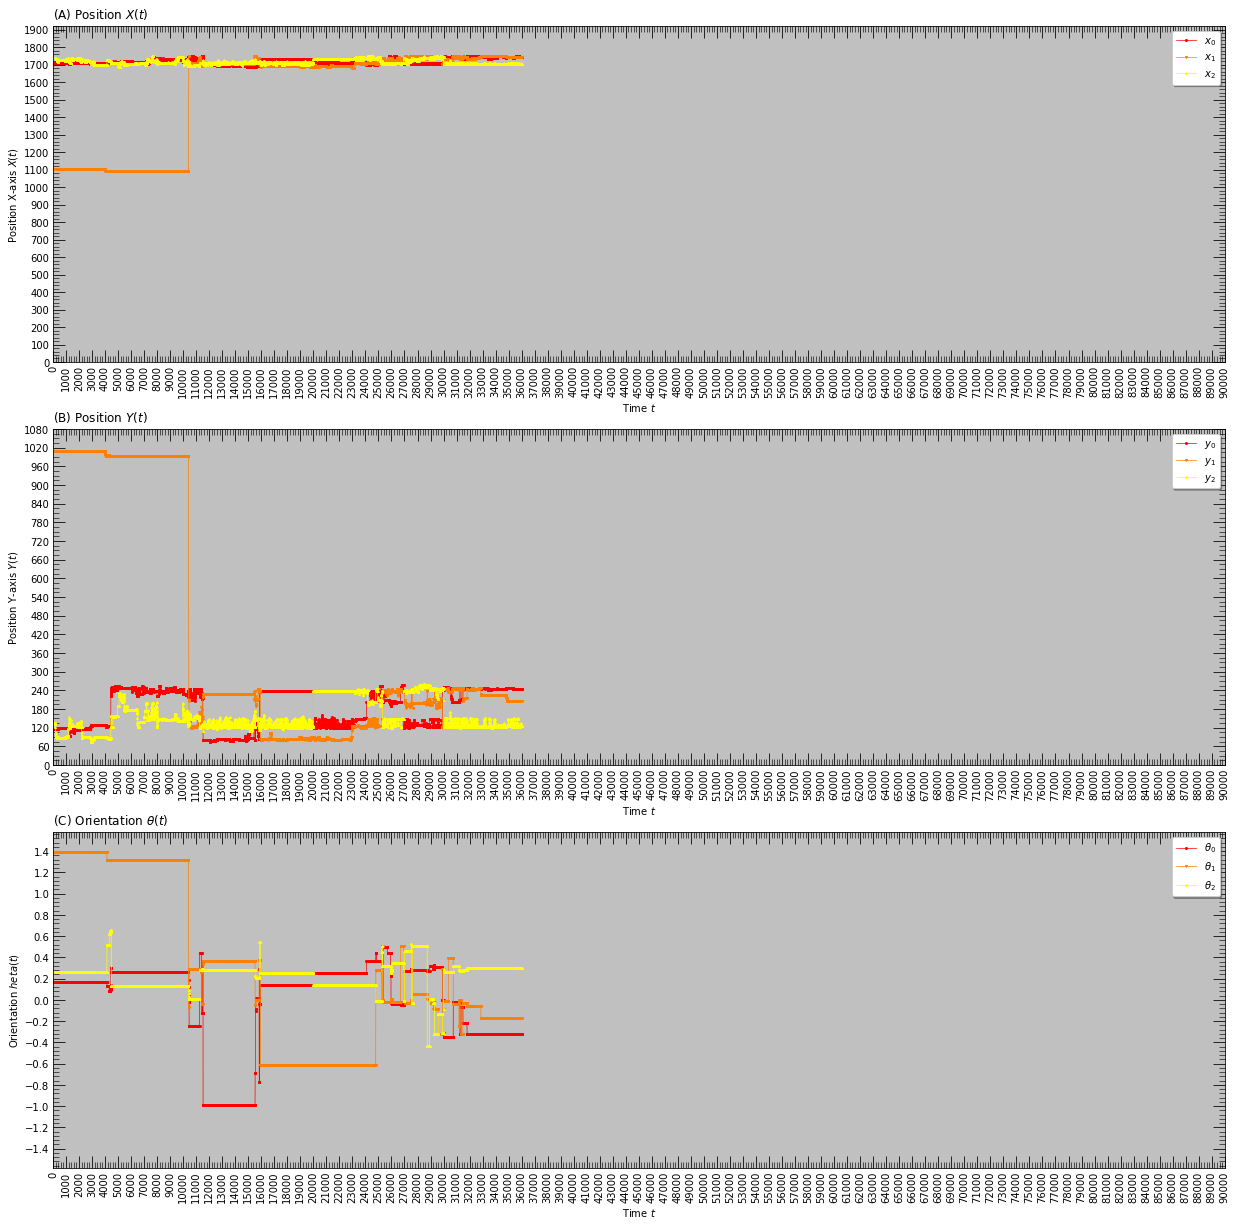

Corrected Orientation


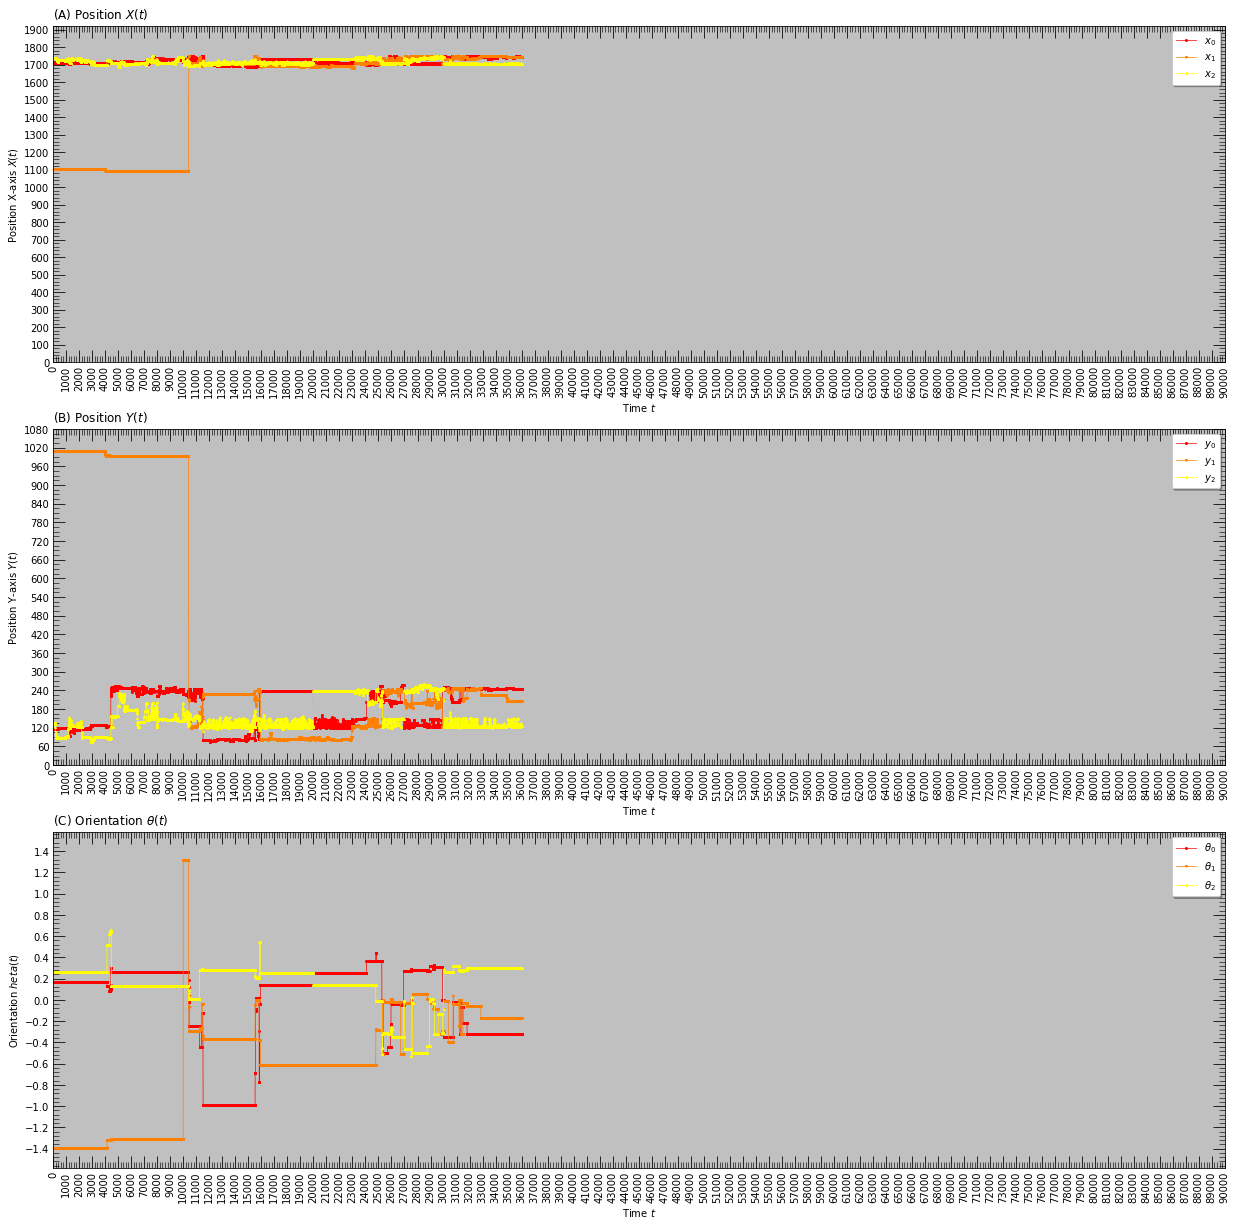

In [10]:
if ordering:
    width = 21
    n_x_breaks = 100
    n_y_breaks = 20
    t0, tf = 0, 90000  # 22200, 24300
    t0_, tf_ = 0, 90000  # 22200, 24300
    t_bounds = [t0_, tf_]
    p_bounds = [[0, 1920], [0, 1080], [-1.58, 1.58]]
    fancy_legend = True

    print("Original")
    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    velocity_threshold = (
        df_full["velocity_x"].abs().quantile(0.9701)
    )  # Velocity per frame limited with half average size of particle
    plt_sp.plot_tracking_evolution(
        df_smooth=df_smooth[
            (
                (df_smooth["velocity_x"] <= velocity_threshold)
                & (df_smooth["velocity_y"] <= velocity_threshold)
            )
        ],
        width=width,
        n_x_breaks=n_x_breaks,
        n_y_breaks=n_y_breaks,
        t_bounds=[t0, tf],
        p_bounds=p_bounds,
        fancy_legend=fancy_legend,
    )

    print("Corrected Orientation")
    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    df_smooth["orientation"] = df_smooth["corrected_orientation"]
    plt_sp.plot_tracking_evolution(
        df_smooth=df_smooth[
            (
                (df_smooth["velocity_x"] <= velocity_threshold)
                & (df_smooth["velocity_y"] <= velocity_threshold)
            )
        ],
        width=width,
        n_x_breaks=n_x_breaks,
        n_y_breaks=n_y_breaks,
        t_bounds=[t0, tf],
        p_bounds=p_bounds,
        fancy_legend=fancy_legend,
    )